In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Kannada-MNIST/sample_submission.csv
/kaggle/input/Kannada-MNIST/Dig-MNIST.csv
/kaggle/input/Kannada-MNIST/train.csv
/kaggle/input/Kannada-MNIST/test.csv


In [2]:
# Import the libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch.optim as optim

In [3]:
# Load the data
train_data = pd.read_csv("/kaggle/input/Kannada-MNIST/train.csv")
valid_data = pd.read_csv("/kaggle/input/Kannada-MNIST/Dig-MNIST.csv")

In [4]:
class KannadaMNIST(Dataset):
    def __init__(self,data):
        self.data = data
        self.img_labels = self.data.iloc[:,0]
        self.img = self.data.iloc[:,1:]
        
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self,idx):
        image = self.img.iloc[idx,:].values.reshape(1,28,28)
        label = self.img_labels.iloc[idx]
        return image,label

In [5]:
train_dataset = KannadaMNIST(train_data)
valid_dataset = KannadaMNIST(valid_data)

In [6]:
batch_size=64
train_dataloader = DataLoader(train_dataset,batch_size = batch_size,shuffle = True)
valid_dataloader = DataLoader(valid_dataset,batch_size = batch_size,shuffle = True)
a,b = next(iter(train_dataloader))
a.data.shape

torch.Size([64, 1, 28, 28])

In [7]:
class MNISTConvNet(nn.Module):
    def __init__(self):
        super(MNISTConvNet, self).__init__()
        self.conv1 = nn.Sequential(
        nn.Conv2d(1, 32, 5, padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
        self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, 5, padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
        self.fc1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(3136, 1024),
        nn.Dropout(0.5),
        nn.Linear(1024, 10)
    )
    def forward(self, x):
        x = x.float()
        x = self.conv1(x)
        x = self.conv2(x)
        return self.fc1(x)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MNISTConvNet().to(device)
model

MNISTConvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=1024, bias=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [9]:
lr = 0.001
num_epochs = 20

loss_fn = nn.CrossEntropyLoss()
optimizer=optim.AdamW(model.parameters(),lr=lr)

In [15]:
# Training Loop

model.train()
train_loss = []
for epochs in range(num_epochs):
    running_loss = 0.0
    num_correct = 0
    
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
        _, idx = outputs.max(dim=1)
        num_correct += (idx == labels).sum().item()
    train_loss.append(running_loss/len(train_dataloader))
print('Loss: {} Accuracy: {}'.format(running_loss/len(train_dataloader),
                             num_correct/len(train_dataloader)))

Loss: 0.11196765663320274 Accuracy: 63.55543710021322


In [16]:
train_loss

[0.06747683203455296,
 0.07439463190304753,
 0.0655490248193653,
 0.07789943386607823,
 0.07917180457115779,
 0.09113836268412523,
 0.08407422224283441,
 0.09693765953759464,
 0.0769845368243859,
 0.07985066132168837,
 0.07432576686907318,
 0.08349076466740954,
 0.0692014964383449,
 0.09602777413981196,
 0.09904493217779245,
 0.10903872636780547,
 0.09906735959034267,
 0.08264854444410398,
 0.09518728425382997,
 0.11196765663320274]

In [17]:
# Validation Loop

model.eval()
valid_loss = []
for epochs in range(num_epochs):
    valid_run_loss = 0.0
    valid_correct = 0
    
    for val_inputs, val_labels in valid_dataloader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        with torch.no_grad():
            val_outputs = model(val_inputs)
            val_loss = loss_fn(val_outputs, val_labels)
            valid_run_loss += loss.item()
            _, val_idx = val_outputs.max(dim = 1)
            valid_correct += (val_idx == val_labels).sum().item()
    valid_loss.append(valid_run_loss/len(valid_dataloader))
print("Validation Loss: {} Accuracy: {}".format(valid_run_loss/len(valid_dataloader),
                                                   valid_correct/len(valid_dataloader)))

Validation Loss: 9.98361883830512e-07 Accuracy: 46.34375


In [18]:
valid_loss

[9.98361883830512e-07,
 9.98361883830512e-07,
 9.98361883830512e-07,
 9.98361883830512e-07,
 9.98361883830512e-07,
 9.98361883830512e-07,
 9.98361883830512e-07,
 9.98361883830512e-07,
 9.98361883830512e-07,
 9.98361883830512e-07,
 9.98361883830512e-07,
 9.98361883830512e-07,
 9.98361883830512e-07,
 9.98361883830512e-07,
 9.98361883830512e-07,
 9.98361883830512e-07,
 9.98361883830512e-07,
 9.98361883830512e-07,
 9.98361883830512e-07,
 9.98361883830512e-07]

## Plotting the train and validation loss

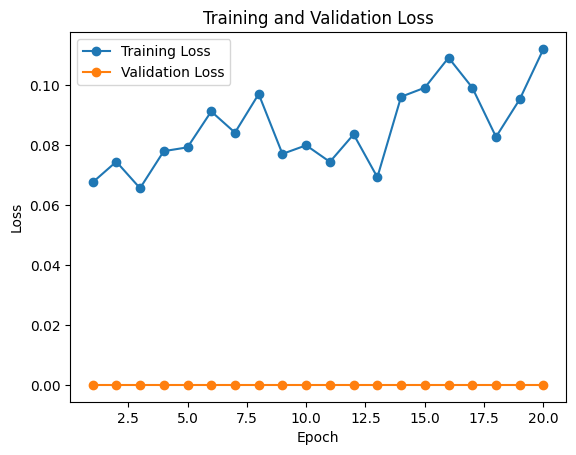

In [20]:
import matplotlib.pyplot as plt

epochs =  np.arange(1, len(train_loss) + 1)
# Plot training loss
plt.plot(epochs, train_loss, label='Training Loss', marker='o')

# Plot validation loss
plt.plot(epochs, valid_loss, label='Validation Loss', marker='o')

# Add labels and a legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Display the plot
plt.show()

## Applying Batch Normalization

In [23]:
import torch.nn as nn

class BatchMNISTConvNet(nn.Module):
    def __init__(self):
        super(BatchMNISTConvNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 5, padding=2),  # Padding should be specified as an integer
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32)  # Batch normalization after the first convolution
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5, padding=2),  # Padding should be specified as an integer
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64)  # Batch normalization after the second convolution
        )
        
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3136, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # Batch normalization after the first fully connected layer
            nn.Dropout(0.5),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = x.float()
        x = self.conv1(x)
        x = self.conv2(x)
        return self.fc1(x)


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BatchMNISTConvNet().to(device)
model

BatchMNISTConvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=1024, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [25]:
lr = 0.001
num_epochs = 20

loss_fn = nn.CrossEntropyLoss()
optimizer=optim.AdamW(model.parameters(),lr=lr)

In [26]:
# Training Loop

model.train()
train_loss = []
for epochs in range(num_epochs):
    running_loss = 0.0
    num_correct = 0
    
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
        _, idx = outputs.max(dim=1)
        num_correct += (idx == labels).sum().item()
    train_loss.append(running_loss/len(train_dataloader))
print('Loss: {} Accuracy: {}'.format(running_loss/len(train_dataloader),
                             num_correct/len(train_dataloader)):.2f)

Loss: 0.004511695144821694 Accuracy: 63.88805970149254


In [30]:
train_loss

[0.05437195641763095,
 0.02665659452906033,
 0.020208081845002196,
 0.01804795229142184,
 0.015411359187677985,
 0.011549201459767674,
 0.01379985848776719,
 0.009196899572622734,
 0.01083874603863615,
 0.007351883944754019,
 0.007713556374582769,
 0.006584019860153756,
 0.006548875618458066,
 0.007365077074993179,
 0.00752754267092985,
 0.005309628611982468,
 0.005735129163300465,
 0.004463751156757937,
 0.004225127485997749,
 0.004511695144821694]

In [27]:
# Validation Loop

model.eval()
valid_loss = []
for epochs in range(num_epochs):
    valid_run_loss = 0.0
    valid_correct = 0
    
    for val_inputs, val_labels in valid_dataloader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        with torch.no_grad():
            val_outputs = model(val_inputs)
            val_loss = loss_fn(val_outputs, val_labels)
            valid_run_loss += loss.item()
            _, val_idx = val_outputs.max(dim = 1)
            valid_correct += (val_idx == val_labels).sum().item()
    valid_loss.append(valid_run_loss/len(valid_dataloader))
print("Validation Loss: {} Accuracy: {}".format(valid_run_loss/len(valid_dataloader),
                                                   valid_correct/len(valid_dataloader)))

Validation Loss: 3.173825916746864e-06 Accuracy: 50.74375


In [29]:
valid_loss

[3.173825916746864e-06,
 3.173825916746864e-06,
 3.173825916746864e-06,
 3.173825916746864e-06,
 3.173825916746864e-06,
 3.173825916746864e-06,
 3.173825916746864e-06,
 3.173825916746864e-06,
 3.173825916746864e-06,
 3.173825916746864e-06,
 3.173825916746864e-06,
 3.173825916746864e-06,
 3.173825916746864e-06,
 3.173825916746864e-06,
 3.173825916746864e-06,
 3.173825916746864e-06,
 3.173825916746864e-06,
 3.173825916746864e-06,
 3.173825916746864e-06,
 3.173825916746864e-06]

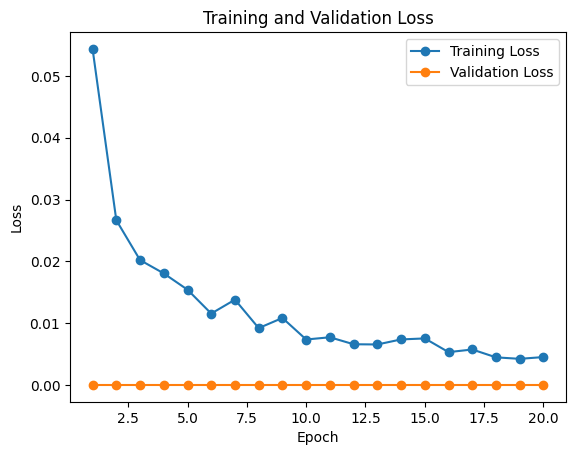

In [28]:
import matplotlib.pyplot as plt

epochs =  np.arange(1, len(train_loss) + 1)
# Plot training loss
plt.plot(epochs, train_loss, label='Training Loss', marker='o')

# Plot validation loss
plt.plot(epochs, valid_loss, label='Validation Loss', marker='o')

# Add labels and a legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Display the plot
plt.show()